
# Flower Classification using CNN

## Isha Sharma, Lei Chen, Kandace Richards

### 1. Introduction

There are millions of beautiful flowers bursting around every corner, & we've been constantly awed by the beauty & uniqueness of each flower. Classifiying different flowers from one another is indeed a challenging task, as there're a plethora of flowers to classify & flowers can appear similar to each other. However, classifiying different flowers species will be advantageous in the fields such as the pharmaceutical industry, botany, agricultural, & trade activities, which is why we thought of performing this task.

The main aim of this project is to solve a Supervised Image Classification problem of classifying the flower types - rose, chamomile, dandelion, sunflower, & tulip. In the end, we’ll have a trained model, which can predict the class of the flower using a Machine Learning algorithm, the Convolutional Neural Networks (CNN).

### 2. Source

The dataset used for this project was the Flowers Recognition dataset from Kaggle, which consists of 5 classes of flower species - rose, chamomile, dandelion, sunflower, & tulip, each having about 800 images. So, we’ve a total of 4242 images to train our model with.

### 3. Procedure

#### 3.1 Importing Libraries

This code should only run once for the entire project because its purpose is to extract data and convert it into an npz file for use during the program. Once the npz file has been created, it does not need to be created multiple times since we hold a reference to these files.

Initally, the following libraries were imported to use in the data conversion process:

In [1]:
# Used for manipulating directory paths
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path

# Data visualisation 
import pandas as pd 
import seaborn as sns

# Image manipulation
from PIL import Image
from skimage.io import imread
import cv2

# Specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import numpy as np 

# Plotting library
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# dl libraries specifically for CNN
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import optimizers

# training set
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

# Tells matplotlib to embed plots within the notebook
%matplotlib inline

import math

#### 3.2 Reading the Dataset
After importing the libraries, we began importing the flower data, using the os & pandas modules. We also, extracted & plotted few sample of different flowers for some visualisation.

In [2]:
# Dataset folder
flowersPath = Path('flowersData')

# Each species of flower is contained in a separate folder, & this is to get all the sub-directories
flowers = os.listdir(flowersPath)
print("Number of types of flowers: ", len(flowers))
print("Types of flowers: ", flowers)

# A list which contains tuples, the type of flower and the corresponding image path
flowersList = []

for species in flowers:
    # Get all the file names
    allFlowers = os.listdir(flowersPath / species)
    # Add them to the list
    for flower in allFlowers:
        flowersList.append((species, str(flowersPath /species) + '/' + flower))

# Build a dataframe   
# load the dataset as a pandas data frame     
flowersList = pd.DataFrame(data=flowersList, columns=['category', 'image'], index=None)
flowersList.head()

Number of types of flowers:  5
Types of flowers:  ['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']


,category,image
0,daisy,flowersData/daisy/14167534527_781ceb1b7a_n.jpg
1,daisy,flowersData/daisy/34718882165_68cdc9def9_n.jpg
2,daisy,flowersData/daisy/5512287917_9f5d3f0f98_n.jpg
3,daisy,flowersData/daisy/476857510_d2b30175de_n.jpg
4,daisy,flowersData/daisy/521762040_f26f2e08dd.jpg


Total number of flowers in the dataset:  4326
Flowers in each category: 
dandelion    1055
tulip         984
rose          784
daisy         769
sunflower     734
Name: category, dtype: int64


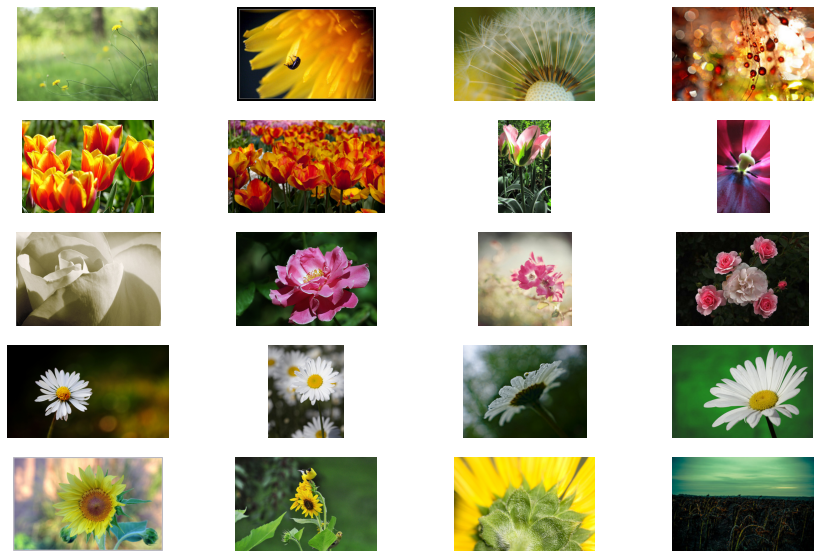

In [3]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowersList))
flowerNum = flowersList['category'].value_counts()
print("Flowers in each category: ")
print(flowerNum)

# A list for storing names of some random samples from each category
RanSamples = []

# Get samples fom each category 
for category in flowerNum.index:
    samples = flowersList['image'][flowersList['category'] == category].sample(4).values
    for sample in samples:
        RanSamples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(RanSamples):
    ax[i//4, i%4].imshow(mimg.imread(RanSamples[i]))
    ax[i//4, i%4].axis('off')
plt.show()  

This snippet is to visualise how many samples we've for each flower type in the bar chart.

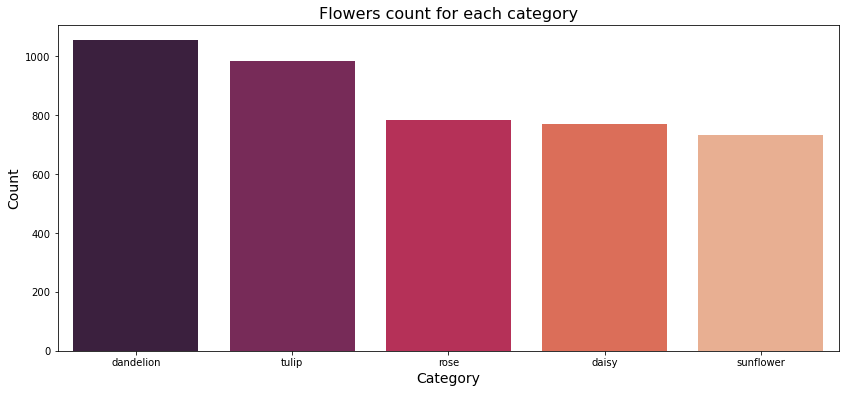

In [4]:
# Let's do some visualization and see how many samples we have for each category
f, axe = plt.subplots(1,1,figsize=(14,6))
sns.barplot(x = flowerNum.index, y = flowerNum.values, ax = axe, palette="rocket")
axe.set_title("Flowers count for each category", fontsize=16)
axe.set_xlabel('Category', fontsize=14)
axe.set_ylabel('Count', fontsize=14)
plt.show()

#### 3.3 Creating Training & Cross Validation sets of the data

After getting the data, we divide the data into cross validation & training set data. We did this by creating a test dir, with two dirs called valDir & trainDir. In the valdir, we have 100 samples of each flower & others to the trainDir.


In [6]:
# Make directory 'test', with 2 sub directories, 'trainDir', & 'validDir'
trainDir = './test/trainDir'
valDir = './test/valDir'
# test_dir = './test/test_dir'
def create_directory(dirName):
    if os.path.exists(dirName):
        shutil.rmtree(dirName)
    os.makedirs(dirName)
    # Inside the trainDir & valDir sub-directories, sub-directories for each flower is created
    for flower in flowers:
        os.makedirs(os.path.join(dirName, flower))
create_directory(trainDir)
create_directory(valDir)


# lists for training & validation image & label
trainImg = []
trainLabel = []
validImg = []
validLabel = []

# for copying 100 samples to the validation dir & others to the train dir
for flower in flowerNum.index:
    samples = flowersList['image'][flowersList['category'] == flower].values
    diffPics = np.random.permutation(samples)
    
    for i in range(100):
        name = diffPics[i].split('/')[-1]
        shutil.copyfile(diffPics[i],'./test/valDir/' + str(flower) + '/'+ name)
        
        try:
            # add image to list
            img = plt.imread('./test/valDir/' + str(flower) + '/'+ name) 
            #resize all of the image to 150*150
            img = cv2.resize(img,(150,150))
            validImg.append(np.array(img))
            
            # add label to list
            if (str(flower)=="dandelion"):
                validLabel.append(0)
            elif (str(flower)=="tulip"):
                validLabel.append(1)
            elif (str(flower)=="rose"):
                validLabel.append(2)
            elif (str(flower)=="daisy"):
                validLabel.append(3)
            elif (str(flower)=="sunflower"):
                validLabel.append(4)
        except Exception as e:
            None
        
    for i in range(101,len(diffPics)):
        name = diffPics[i].split('/')[-1]
        shutil.copyfile(diffPics[i],'./test/trainDir/' + str(flower) + '/' + name)

        try:
            # add image to list
            img = plt.imread('./test/trainDir/' + str(flower) + '/' + name) 
            #resize all of the image to 150*150
            img = cv2.resize(img,(150,150))
            trainImg.append(np.array(img))
            
            # add label to list
            if (str(flower)=="dandelion"):
                trainLabel.append(0)
            elif (str(flower)=="tulip"):
                trainLabel.append(1)
            elif (str(flower)=="rose"):
                trainLabel.append(2)
            elif (str(flower)=="daisy"):
                trainLabel.append(3)
            elif (str(flower)=="sunflower"):
                trainLabel.append(4)
        except Exception as e:
            None
           
# Let computer read the 5 category
validLabel = to_categorical(validLabel,num_classes = 5)
trainLabel = to_categorical(trainLabel,num_classes = 5)
print(validLabel)
print(trainLabel)

# Make new test and validation images as pixcel
validImg=np.array(validImg)
validImg=validImg/255

trainImg=np.array(trainImg)
trainImg=trainImg/255

print("\nLengths of the corresponding array dimensions: \n")
print(np.shape(validImg),np.shape(validLabel),np.shape(trainImg),np.shape(trainLabel))

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]

Lengths of the corresponding array dimensions: 

(500, 150, 150, 3) (500, 5) (3818, 150, 150, 3) (3818, 5)


### What is Neural Network?

 <img src="images/nn.gif" width="800" height="400">

A Neural network is basically a system of softwares patterned after the working of neurons in the human brain. Just like how human brain has interconnected neurons that process information, a Neural Network also has interconnected artificial neurons called as nodes that takes some input, processes those inputs in layers to produce the output. A neural network has basically 3 layers:

1. Input Layer : This layer accepts input in the form of array of numbers.
2. Hidden Layers : This layer performs some calculations on the given input & does feature extraction on the data to locate patterns. There are weights assigned in each layer whose weighted sum is calculated with the inputs & a bias is added. Weights are basically random values that are assigned between each node in the network. Different activation functions are applied to the hidden layers for extracting specific features. A network can contain multiple hidden layers.
3. Output Layer : This layer produces the desired output after a number of iterations.

 <img src="images/Untitled_Artwork2.png" width="800" height="400">

### Why the Convolutional Neural Network (CNN) for image classification & not the simple Neural Network?

Convolutional Neural Network is one of the classes of the deep learning Neural Networks. They’re most commonly used to analyze visual imagery & are frequently working behind the scenes in image classification. They can be found at the core of everything from Facebook’s photo tagging to self-driving cars. They’re now a crucial part of a lot of sectors from healthcare to security.

Image classification is the process of taking an input (like a picture) & outputting a class (like rose or tulip) or a probability that the input is a particular class (“there’s a 90% probability that this input is a rose”).

CNNs have an input layer, hidden layers, & output layer. The hidden layers usually consist of convolutional layers, activation layers, pooling layers, & fully connected layers.

- Convolutional layers : Convolution layer applies a convolution operation to the input for passing the result to the next layer. Each convolution processes the data only for its respective field.

- Activation Function layers: It is used to determine the output of a neural network (like rose/tulip). It can also be attached between two different neural networks. The activation functions could be Sigmoid, RELU, softmax etc..

- Pooling layers : It is responsible for reducing the spatial size of the convoluted feature. Pooling combines the output of neuron cluster at one layer into a single neuron in the next layer.

- Fully connected layer : It connects every neuron in one layer to every neuron in the next layer.

In a convolutional layer, neurons only receive input from a subarea of the previous layer. In a fully connected layer, each neuron receives input from every element of the previous layer.

 <img src="images/cnn2.gif" width="600" height="300">

A classic CNN architecture would look something like this:

 <img src="images/Untitled_Artwork3.png" width="800" height="100">

### 4. Creating the CNN network

 <img src="images/pic.jpg" width="800" height="230">


#### Creating the model
We are using Conv2D and MaxPooling2D layers as the convolutional base:
   - Conv2D: The first required Conv2D parameter is the number of filters that the convolutional layer will learn.    
   - MaxPooling2D: used to reduce the spatial dimensions of the output volume.
We used ReLU as our activation function: 
 <img src="images/main-qimg-9e3b87e175577fe97da51fd1a2b50eac.png" width="300" height="230">
   

In [7]:
def createModel():
    model = Sequential()
    #  learn a total of 32 filters, kernel size 3x3
    model.add(Conv2D(32, (3, 3), input_shape=(150,150,3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    #  learn a total of 64 filters, kernel size 3x3
    model.add(Conv2D(64, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    #  learn a total of 96 filters, kernel size 3x3
    model.add(Conv2D(96, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    #  learn a total of 128 filters, kernel size 3x3
    model.add(Conv2D(128, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Add Dense layers on top
    '''
    1. flatten the 3D output to 1D
    2. add dense layer to top
    '''
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    return model

#### Compiling the model & summary
Initialize all parameters and compile our model with rmsprop optimizer; here there batch is 128 with 50 epochs.

model.summary() is used to see all parameters and shapes in each layers in our models. 
You can observe that total parameters are 276, 138 and total trainable parameters are:276, 138. 
Non-trainable parameter is 0.

In [8]:
# Compile
model = createModel()
batch_size = 128
epochs = 50

model.compile(loss='categorical_crossentropy',
             optimizer='RMSProp',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       1

### Fitting on the Training set & making predcitons on the Validation set

In [9]:
# Create data argument to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (90, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        shear_range=0.1,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False  # randomly flip images
)
datagen.fit(trainImg)

# start training
'''
verbose - 0 shows nothing; 1 will show animated progress bar; 2 will only mention the number of epoch.
batch_size - the number of samples that will be propagated through the network.
epochs - an arbitrary cutoff, use to separate training into distinct phases.
'''
History = model.fit(trainImg, trainLabel, batch_size=batch_size, epochs = epochs, validation_data = (validImg, validLabel),verbose=1)

Epoch 1/50
30/30 [==============================] - 153s 5s/step - loss: 1.6455 - accuracy: 0.3127 - val_loss: 1.4196 - val_accuracy: 0.4320
Epoch 2/50
30/30 [==============================] - 133s 4s/step - loss: 1.2618 - accuracy: 0.4675 - val_loss: 1.3355 - val_accuracy: 0.3580
Epoch 3/50
30/30 [==============================] - 126s 4s/step - loss: 1.1168 - accuracy: 0.5534 - val_loss: 0.9574 - val_accuracy: 0.6340
Epoch 4/50
30/30 [==============================] - 125s 4s/step - loss: 1.0165 - accuracy: 0.5969 - val_loss: 1.0309 - val_accuracy: 0.5940
Epoch 5/50
30/30 [==============================] - 127s 4s/step - loss: 0.9584 - accuracy: 0.6291 - val_loss: 1.2061 - val_accuracy: 0.5180
Epoch 6/50
30/30 [==============================] - 150s 5s/step - loss: 0.8847 - accuracy: 0.6477 - val_loss: 0.9601 - val_accuracy: 0.6480
Epoch 7/50
30/30 [==============================] - 123s 4s/step - loss: 0.8034 - accuracy: 0.6812 - val_loss: 0.8239 - val_accuracy: 0.6740
Epoch 8/50
30

 #### Visualizing Predictons on the Validation Set

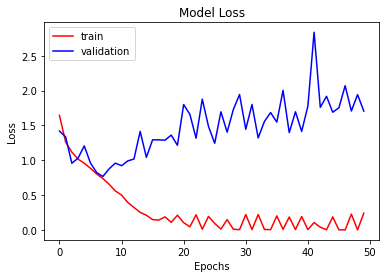

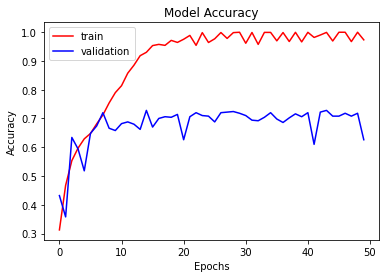

In [10]:
# Loss
plt.plot(History.history['loss'], "r")
plt.plot(History.history['val_loss'], "b")
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.show()

# Accuracy
plt.plot(History.history['accuracy'], "r")
plt.plot(History.history['val_accuracy'],"b")
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.show()

### 4. Conclusion 
In this project, we utilized a Convolutional Neural Network (CNN) to predict flowers of 5 types using the flower recognition dataset from Kaggle (Daisy, Dandelion, Rose, Sunflower, and Tulip), which consisted 4242 images. We used a simple CNN to do training & predictions. The images were first preprocessed into pixels & used for random sample images that we trained our model with. After training, we got 97.07% accuracy & 65% validation accuracy. 

While training our model, we ran into the issue of not having a high validation accuracy. Adding more CNN layers could possibly help the validation accuracy to make the percentage higher and make the data we receive more reliable